In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy
import os
import pandas as pd
from collections import Counter
from scipy import stats
import glob
from sklearn.cluster import MeanShift, estimate_bandwidth
from scipy import stats, signal
from sklearn.linear_model import LinearRegression
from sklearn.cluster import MeanShift
from numpy.random import default_rng
from scipy.optimize import curve_fit
import gamry_parser as parser

rng = default_rng()

#area	0.42	cm^2 
constant=2.69E+05
nelectrons=1 #	e
Diffusion=  7.20E-06# ferrocene cm^2/s
Concentration=5.00E-06#ferrocene mol/cm^3
#speed	3.00E+00	volts/s
area=1

areaConstant = constant*(nelectrons**1.5)*(Diffusion**0.5)*Concentration
areaConstant

#folder=r"S:\Research\Chip Fabrication Meeting Notes (Do not share without permission)\SharedData\CV measurements\2022-DEC-01 1757 #1]_Biased_MPA_FunctionalizationOnChip_" 
folder=r"C:\Users\bashc\Downloads" 
 
 
fileFolder=    folder
outFolder=    folder
#allFiles = glob.glob( folder+"/**/*.csv", recursive=True)
#allFiles=[os.path.dirname(os.path.dirname(x)) for x in allFiles if 'Voltammogram' in x]

allFiles = glob.glob( folder+"/**/*.dta", recursive=True)

len(allFiles)

12

In [3]:
def annot(xmax,ymax,text,dir, ax=None):
 
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="data",              arrowprops=arrowprops, bbox=bbox_props, ha="left", va="top")
    if dir>0:
        ax.annotate(text, xy=(xmax, ymax), xytext=(xmax-.1,ymax+.5), **kw)
    else:
        ax.annotate(text, xy=(xmax, ymax), xytext=(xmax+.02,ymax+.5), **kw)

def annot_max(x,y,text,dir, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()

    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="data",              arrowprops=arrowprops, bbox=bbox_props, ha="left", va="top")
    if dir>0:
        ax.annotate(text, xy=(xmax, ymax), xytext=(xmax-.1,ymax+.5), **kw)
    else:
        ax.annotate(text, xy=(xmax, ymax), xytext=(xmax+.02,ymax+.5), **kw)
        
def loadPine(dataDir):
    filePot = dataDir + r"\\experiment\\results\\Measured Potential.csv"
    fileCur = dataDir + r"\\experiment\\results\\Measured Current.csv"
    try:
        pot=pd.read_csv(  filePot ) 
        cur=pd.read_csv(  fileCur ) 
        time=cur['Time (s)']
        pot =np.interp(cur['Time (s)'], pot['Time (s)'], pot['Potential (V)'])
    except:
        pot=pd.read_csv(  filePot,sep='\t' ) 
        cur=pd.read_csv(  fileCur,sep='\t' ) 
        time=cur['Time (s)']
        pot =np.interp(cur['Time (s)'], pot['Time (s)'], pot['Potential (V)'])
    
    
    cur=cur['Current (A)']
    scanRate =np.zeros_like(cur)
    cycle =np.zeros_like(cur)
    totalcycle =np.zeros_like(cur)
    
    peakIDX, _ =  scipy.signal.find_peaks(-1*pot, height=0)
    peakIDX2, _ =  scipy.signal.find_peaks(pot, height=0)
    minPeaks=np.min([len(peakIDX),len(peakIDX2)])
    
    peakIDX=np.sort(np.concatenate([peakIDX2,peakIDX,[0,len(pot)-1]]))
    for i in  range(0,len(peakIDX)-1):
        scanRate[peakIDX[i]:peakIDX[i+1]]=(pot[peakIDX[i+1]]-pot[peakIDX[i]])/(time[peakIDX[i+1]]-time[peakIDX[i]])
    nCycles=0    
    startPot=pot[0]
    startDirection = scanRate[0]>0
    startIndex=time[0]
    for i in range(len(scanRate)):
        curDirection =scanRate[i]>0
        if np.abs(pot[i]-startPot)<.01 and time[i]-startIndex>5 and startDirection==curDirection:
            nCycles+=1
            startIndex=time[i]
        cycle[i]=nCycles
   
    totalcycle[:]=(nCycles)
    totalcycle[1]=minPeaks
  
    cv=pd.DataFrame({'Time':time,'V':pot ,'C':cur, 'scanrate':scanRate, 'cycle':cycle,'totalcycle':totalcycle })
   
    cc+=1
    return cv



def CalcAreaFromOxide(CV,fig):
    nCycles=float(CV.totalcycle.iloc[0])
   
    timeStep =np.mean(np.diff(CV.Time))
    plt.plot(CV.V*1000,CV.C*1e6)
    value =   CV.C *-1e6
    height = np.max(value)/2

    peak , _ =  scipy.signal.find_peaks(value, height=height)
    peakVoltageBelow = np.mean(CV.V[peak])
    peakCurrentBelow = np.mean(CV.C[peak])
    CV2=CV.loc[ (np.abs(CV.V- peakVoltageBelow)<.25) & (CV.scanrate<0)]
    height = np.min(CV2.C)/2
    FWHM=CV2.V.loc[ np.abs(CV2.C-height)<5e-6]
    FWHM_b=np.max(FWHM)-np.min(FWHM)
   
    plt.plot(CV2.V*1000,CV2.C*1e6)

    #print( np.sum(CV2.C-CV2.C.iloc[0])*timeStep*-1 ,'C')
    #print( np.sum(CV2.C-CV2.C.iloc[0])*timeStep* -6.24150975*1e18 ,'electrons')
    #print( np.sum(CV2.C-CV2.C.iloc[0])*timeStep* -6.24150975*1e18 *1.47968E-19/2*1e4,'cm^2')
    C_B=  np.sum(CV2.C-CV2.C.iloc[0])*timeStep/nCycles
    areaBelow_m2= np.sum(CV2.C-CV2.C.iloc[0])*timeStep * -6.24150975*1e18*1.47968E-19/2/nCycles/2
    #print( areaBelow_m2*1e4, 'cm^2')


    height = np.max(CV.C *1e6)*.75
    peak , _ =  scipy.signal.find_peaks(CV.C *1e6, height=height)
    
    peakVoltageAbove = np.mean(CV.V[peak])
    peakCurrentAbove = np.mean(CV.C[peak])


    CV2=CV.loc[ (np.abs(CV.V-    peakVoltageAbove)<.25) & (CV.scanrate>0)]
    height = np.max(CV2.C) /2
    FWHM=CV2.V.loc[ np.abs(CV2.C-height)<5e-6]
    FWHM_a=np.max(FWHM)-np.min(FWHM)
    
    plt.plot(CV2.V*1000,CV2.C*1e6)
    plt.ylabel('Current (uA)')
    plt.xlabel('Potential (mV) vs Ag/AgCl')
   
    C_A=np.sum(CV2.C-CV2.C.iloc[0])*timeStep/nCycles
    areaAbove_m2= np.sum(CV2.C-CV2.C.iloc[0])*timeStep * 6.24150975*1e18*1.47968E-19/2/nCycles/2
    
    
    E0=(peakVoltageBelow+peakVoltageAbove )/2.0
    C_E0=np.mean( CV.C.loc[ np.abs(CV.V-E0)<.05])
    Er=(peakVoltageBelow-E0)
    Eo=(peakVoltageAbove-E0 )
    
    voltageTexts ='E0: %.2f mV\n'%( E0*1000)
    voltageTexts +='E-:\n   %.2f mV\n   ip: %.2f uA\n   FWHM: %.2f mV\n   Q: %.2f mC\n   ~e: %.2f \n' % ((Er+E0)*1000,peakCurrentBelow*1e6,FWHM_b*1000,C_B*1000,90.6/(FWHM_b*1000) )
    voltageTexts +='E+:\n   %.2f mV\n   ip: %.2f uA\n   FWHM: %.2f mV\n   Q: %.2f mC\n   ~e: %.2f \n'%( (Eo+E0)*1000,peakCurrentAbove*1e6,FWHM_a*1000,C_A*1000,90.6/(FWHM_a*1000) )
    voltageTexts +='deltaE: %.2f mV'% (-1000*( Er-Eo))
    
    sig_peaks=np.array([E0,Er+E0,Eo+E0])*1000
    contur_min=[0,0,0]
    contur_max=np.array([C_E0,peakCurrentBelow,peakCurrentAbove])*1e6
    plt.vlines(x=sig_peaks, ymin=contur_min, ymax=contur_max,colors='r')
    
    area_stats={'peakVoltageBelow':peakVoltageBelow,
            'peakCurrentBelow':peakCurrentBelow,
            'areaBelow_m2':areaBelow_m2,
            'peakVoltageAbove':peakVoltageAbove,
            'peakCurrentAbove':peakCurrentAbove,
            'areaAbove_m2':areaAbove_m2,
            'E0':E0,
            'deltaE':np.abs(Er-E0),
            'FWHM':1
           }
    
    areaB='\nArea: %.2f cm^2 Disk Radius:%.2f cm'%( area_stats['areaBelow_m2']*1e4, np.sqrt(area_stats['areaBelow_m2']*1e4/3.1415))
    areaB+='\nArea: %.2f cm^2 Disk Radius:%.2f cm'%( area_stats['areaAbove_m2']*1e4, np.sqrt(area_stats['areaAbove_m2']*1e4/3.1415))
    
    
    plt.gcf().text(1,.25,   voltageTexts+'\n' +areaB + '\n'  , fontsize=10)
    #annot(area_stats['peakVoltageBelow']*1000,area_stats['peakCurrentBelow']*1e6,'%.2f E(mV)' % (1000*(Er+E0)),1 )
    #annot(area_stats['peakVoltageAbove']*1000,area_stats['peakCurrentAbove']*1e6,'%.2f E(mV)' % (1000*(Eo+E0)),1 )
    
    return area_stats

def gaussian(x, A, x0, sig):
    #return A*np.exp(-(x-x0)**2/(2*sig**2))
    return A*np.exp( -.5*((x-x0)/sig)**2)
 
def multi_gaussianD(x, pars):
    slope=pars[0]
    offset=pars[1]
    fit=x*slope+offset
    fit[fit<0]=0
    plus=2
    nGuass=int((len(pars)-plus)/3)
    for i in range(nGuass):
        fit += gaussian(x, pars[i*3+plus], pars[i*3+plus+1], pars[i*3+plus+2])
    return fit

def multi_gaussian(x, *pars):
    return multi_gaussianD(x, pars)

def FindMolecules(CV,area_cm2): 
    #CV=CV.loc[(CV.scanrate<0) & (CV.cycle==0)]
    
    C=np.array(CV.C)*-1
    VV=np.array(CV.V)*-1
    CC=C


    model = LinearRegression()
    x = np.array(VV).reshape((-1, 1))
    y = np.array( CC)
    model.fit(x,y)

    slope=model.coef_.ravel()[0]
    fit=( VV* slope)

    dV=np.abs(np.mean(np.diff(CV.V)))

    C=CC-fit
    intercept=-1*np.min(C)
    C=C+intercept
    preHeight=np.sum(C)

    IC=C[(VV>.4)  ]
    IV=VV[(VV>.4)  ]
    peakMax=IV[np.argmax(IC)]

     
    C=C/np.max(C) 

    X=[]
    for i in range(len(C)):
        for j in range(int(C[i]*6000)):
            X.append(VV[i]+rng.standard_normal()*dV*3)

    X=np.array(X)
    Y=X.reshape(-1, 1)
    print('Estimate bandwidth')
    bandwidth = estimate_bandwidth(Y, quantile=0.15, n_samples=5000)
    guessedCoverage=[]
    bestGuess=None
    for size_BW in range(1,6):
        print(f'Mean shift {size_BW}')
        ms = MeanShift(bandwidth=bandwidth/size_BW, bin_seeding=True)
        ms.fit(Y)
        labels_unique = np.unique(ms.labels_)
        cluster_centers=ms.cluster_centers_.ravel()
        std=[]
        weights=[]
        for l in labels_unique:
            YY= X[ms.labels_==l]
            weights.append( len(YY))
            std.append( np.std(YY))
        weights=np.array(weights)
        weights=weights/np.sum(weights)

        guess =[ slope,-1*intercept]
        for i in range(len(cluster_centers)):
            guess.append(weights[i])
            guess.append(cluster_centers[i])
            guess.append(std[i] )

        guess=np.array(guess).ravel().astype(float)  

        back=multi_gaussianD(VV, guess)       
        scale=preHeight/np.sum(back)

        guess =[ slope,-1*intercept]
        for i in range(len(cluster_centers)):
            guess.append(weights[i]*scale*.7)
            guess.append(cluster_centers[i])
            guess.append(std[i])

        guess=np.array(guess).ravel().astype(float)  

        print('Guassian Fit')
        back=multi_gaussianD(VV, guess)      

        if np.any(np.abs( cluster_centers-peakMax)<.001)==False:
            vP=np.mean( CC[np.abs(VV-peakMax)<.01])-np.mean( back[np.abs(VV-peakMax)<.01])
            guess=np.concatenate([guess, [vP,peakMax,.01]])

        try:
            popt, pcov = curve_fit(multi_gaussian,  VV ,CC, guess)

            plus=2
            nGuass=int((len(popt)-plus)/3)
            dum=np.zeros_like(popt)
            dum[:plus]=popt[:plus]
            back=multi_gaussianD(VV, dum)
            actual=np.zeros_like(back)
            hasPeak=False
            for i in range(nGuass):
                amp=popt[i*3+plus]
                energy=popt[i*3+plus+1]
                sig=popt[i*3+plus+2]
                g1=gaussian(VV, amp, energy, sig)

                if np.abs(energy-peakMax)<.1 and sig<.04   :
                    bestPeakParams = {'energy':energy, 'range': [  energy - 4*sig,energy + 4*sig], 'amp':amp}
                    print(f'peak {energy} range: {  energy - 2*sig},{energy + 2*sig} amp:{amp}' )
                    actual+=g1
                    hasPeak=True
                else:
                    back+=g1

            if hasPeak:
                
                
                error=np.mean((CC-(back+actual))**2)
                Q= dV*np.abs(np.sum(actual)/np.mean(CV.scanrate)) #C
                r_cm=400 /10000
                areaCM2=r_cm*r_cm*3.14
                M=Q/9.648533212e4 #9.648533212e4 C⋅mol−1
                Mol=M*6.02214076e23
                MolPcm2=Mol/areaCM2
                dI=[error,back,actual,energy,Q,Mol,bestPeakParams]
                if len(guessedCoverage)>0:
                    if error<bestGuess[0]:
                        bestGuess=dI
                else:
                    bestGuess=dI

                guessedCoverage.append([error,energy,Q,Mol])
        except:
            pass
            #print('%.2f V'%(-1*energy),'%.2E C,'%Q,'%.3E molecules'%(Mol),',%.3E molecules/cm^2'%(MolPcm2),',%.3E molecules/nm^2'%(Mol/7.85375E+11) )

   
    actual = -1*(bestcurves[2]+bestcurves[1])
    bestParams= bestcurves[6]
    VV2=VV[ (VV>bestParams['range'][0]) & (VV<bestParams['range'][1])]
    actual = actual[ (VV>bestParams['range'][0]) & (VV<bestParams['range'][1])]

    time = np.abs( ( bestParams['range'][0] - bestParams['range'][1] )/np.mean(CV.scanrate))
    
    plt.plot(-1*VV2,( np.linspace(actual[0],actual[-1], len(VV2)) )/area_cm2*1e6, label='Simple')
    
    Qpeak=  np.sum(actual) *dV*time  #uC
    QBack=  (actual[-1] + actual[0])/2*time *dV#assume straight line
    flatBackQ_uC_cm2=np.abs((Qpeak-QBack)/area_cm2 *1e6)
    
    plt.plot(-1*VV,-1*(bestGuess[2]+bestGuess[1])/area_cm2*1e6, label='Peak')
    plt.plot(-1*VV, -1*bestGuess[1]/area_cm2*1e6,'--', label='Background')
    
    return guessedCoverage,bestGuess, flatBackQ_uC_cm2,VV

def sigTest(x, A, x0, sig, m,b,A2,sig2,x2,p):
    xx=x-x0
    xx2=np.exp(-1*(x-x2)*sig2)
    return A2*xx2/(1+xx2 ) +b+m*x 

def gaussian_Lin2(x, A, x0, sig, m,b,p):
    xx=x-x0
    return A*np.exp( -.5*np.abs(xx/sig)**p)+b+m*x

def gaussian_Lin3(x, A, x0, sig, m,b,A2,sig2,x2,p):
    xx=x-x0
    xx2=np.exp(-1*(x-x2)*sig2)
    return A*np.exp( -.5*np.abs(xx/sig)**p)+A2*xx2/(1+xx2 ) +b+m*x

def MajoritySlope(volts,current,direction):
    cross = volts[ np.argmin( np.abs(current))]
    if (direction)>0:
        vCross= volts[volts<cross]
        cCross= current[volts<cross]
    else:
        vCross= volts[volts>cross]
        cCross= current[volts>cross]
    slopes=[]
     
    for i in range( len(cCross)-8):
        slopes.append( (cCross[i+8] -cCross[i])/(vCross[i+8] -vCross[i]))
    v,bins=np.histogram(slopes)
    
    ind=np.argmax(v)
   
    slopeThresh=(bins[ind+1]+bins[ind])/2
    
    cs=[]
    vs=[]
    for i in range( len(cCross)-8):
        if  (cCross[i+8] -cCross[i])/(vCross[i+8] -vCross[i])<slopeThresh:
            cs.extend(cCross[i:i+7])
            vs.extend(vCross[i:i+7])

    p= np.polyfit(vs,cs, 1)
    return p

def DuckParams(filename,CV):
    
    CV_sub=CV.loc[(CV.scanrate<0) & (CV.cycle==0)]
    f, ax = plt.subplots()
    plt.suptitle( os.path.basename( filename))
     
    plt.plot(CV_sub.V*1000,1e6*CV_sub.C)        
  
    plt.ylabel("Current (uA)")
    plt.xlabel('Potential (mV vs Ag/AgCl)')

                       
    CV_up=CV.loc[(CV.scanrate>0) & (CV.cycle==1)]
    volts_up=np.array(CV_up.V)
    current_up=np.array(CV_up.C) 
    ind=np.argsort(volts_up)
    volts_up=volts_up[ind]
    current_up=current_up[ind]
    
    pAbove = MajoritySlope(volts_up,current_up,1)
    scanRate=np.mean(np.abs(CV.scanrate*1000))
    
    dvdP=np.mean(np.diff(volts_up))
    peakParams ={ }
    try:
        volts=np.array(CV_sub.V)
        current=np.array(CV_sub.C) 
        
        pBelow = MajoritySlope(volts,current,-1)
        
        peakIndex=np.argmin(current)
        peakV= volts[peakIndex ]
        Eb=peakV
        peakC= current[peakIndex ]
        #          A         x    sig    m     b    A2            sig2     x2     power
        guess=[ peakC*.8,  peakV,  .1, .0001,  0,    peakC*.5,      10   ,  peakV ,  2]
        try:
            poptB, pcov = curve_fit(gaussian_Lin3,  volts ,current, guess) 
            #plt.plot(volts*1000,1e6* gaussian_Lin3(volts,poptB[0],poptB[1],poptB[2],poptB[3],poptB[4],poptB[5],poptB[6] ,poptB[7],poptB[8]))
        except:
            pass
        
        flat_Current =current_up-volts_up*pAbove[0]-pAbove[1]
        flat_Current=flat_Current[flat_Current>0]
        
        dt=scanRate/dvdP
        Q=np.sum(flat_Current)*dt
        IMin= peakC
        IMax=  np.poly1d(pBelow)(peakV)
        plt.plot( volts_up*1000,1e6*np.poly1d(pBelow)(volts_up),'r' )
        Ip=np.abs(IMax-IMin)
        text=  'Ip= %.2f uA\nEp= %.2f mV\n'%( Ip*1e6,1000*peakV)
        text += 'Iback = %.2f uA\nQ = %.2f uC\n'%(1e6* pBelow[-1], Q*1e6)
        text += 'Kt = %.2f ms-1\nscanrate = %.2f'%( 1000*Ip/Q,scanRate)
        
        peakParams ['Ip_rx(uA)']=Ip*1e6
        peakParams ['Ep_rx(mV)']=1000*peakV
        peakParams ['Iback_rx(uA)']=1e6*pBelow[-1]  
        peakParams [ 'Q_rx (C)']=Q  
        peakParams [ 'Kt_rx(ms-1)']=1000*Ip/Q
        peakParams ['scanrate (mV/s)']=np.mean(np.abs(CV.scanrate*1000))
        plt.text(.75, .5, text, ha='left', va='top', transform=ax.transAxes)
        plt.vlines(x=1000*peakV, ymin=1e6*IMin, ymax=1e6*IMax,colors='r')
        
    except:
        pass

    try:
        
        
        plt.plot(volts_up*1000,1e6*current_up,label=os.path.basename(filename))
    
        current_up=current_up[(volts_up>0)& (volts_up<.9)]
        volts_up=volts_up[(volts_up>0) & (volts_up<.9)]
        flat_Current =current_up-volts_up*pAbove[0]-pAbove[1]
        

        peakIndex=np.argmax(current_up)
        peakV= volts_up[peakIndex ]
        peakC= current_up[peakIndex ]
        if np.abs(peakV-np.max(volts_up))<.05:
            peakIndex=np.argmax(flat_Current)
            peakV= volts_up[peakIndex ]
            peakC= flat_Current[peakIndex ]
            
        hm=np.max(flat_Current)/2   
        fwhm=peakIndex
        for i in range(peakIndex,len(flat_Current)):
            if flat_Current[i]<hm:
                fwhm=i
                break
        for i in range(peakIndex,0,-1):
            if flat_Current[i]<hm:
                #print([volts_up[i ],volts_up[fwhm ]])
                #plt.plot([volts_up[i ]*1000,1000*volts_up[fwhm ]],[1e6*current_up[i ],1e6*current_up[fwhm ]])
                fwhm=2*(volts_up[i ]-volts_up[fwhm ])
                 
                break
        
        sigma =   2.355*fwhm
        

       
        #          A         x    sig    m     b    A2            sig2       x2      power
        guess=[ peakC*.8,  peakV,  .1, .0001,  0,    peakC*.1,      10   ,  peakV ,  2]
        try:
            poptU, pcov = curve_fit(gaussian_Lin3,  volts_up ,current_up, guess) 
            #plt.plot(volts_up*1000,1e6* gaussian_Lin3(volts_up,poptU[0],poptU[1],poptU[2],poptU[3],poptU[4],poptU[5],poptU[6] ,poptU[7],poptU[8]))
            #fwhm=poptU[2]/2.355
        except:
            try:
                guess=[ peakC*.8,  peakV,  sigma, .0001,  0,    peakC*.1,      10   ,  peakV ,  2]
                poptU, pcov = curve_fit(gaussian_Lin3,  volts_up ,current_up, guess) 
                #plt.plot(volts_up*1000,1e6* gaussian_Lin3(volts_up,poptU[0],poptU[1],poptU[2],poptU[3],poptU[4],poptU[5],poptU[6] ,poptU[7],poptU[8]))
                #fwhm=poptU[2]/2.355
            except:
                pass
        
        flat_Current =current_up-volts_up*pBelow[0]-pBelow[1]
        flat_Current=flat_Current[flat_Current>0]
        dt=CV.scanrate[0]/dvdP
        Q=np.sum(flat_Current)*dt
        IMax= peakC
        IMin=  np.poly1d(pAbove)(peakV)
        plt.plot( volts_up*1000,1e6*np.poly1d(pAbove)(volts_up) ,'r')
        Ip=np.abs(IMax-IMin)
        text='Ip= %.2f uA\nEp= %.2f mV\n'%( Ip*1e6,1000*peakV)
        text += 'Iback = %.2f uA\nQ = %.2f uC\n'%(1e6* pAbove[-1], Q*1e6)
        #text += 'FWHM = %.2f mV\n'%(1000* fwhm)
        text += 'E0 = %.2f mV\ndE = %.2f mV\nKt = %.2f ms-1\n'%(1000*(Eb+peakV)/2,1000*np.abs(Eb-peakV),1000*Ip/Q)
        plt.text(.01, .99, text, ha='left', va='top', transform=ax.transAxes)
        
        peakParams['Ip_ox(uA)']=Ip*1e6
        peakParams['Ep_ox(mV)']=peakV*1000
        peakParams['Iback_ox (uA)']=1e6*pAbove[-1]
        peakParams['Q_ox (uC)']=Q*1e6
        peakParams['Kt_ox (ms-1)']=1000*Ip/Q
        peakParams['E0(mV)']=1000*(Eb+peakV)/2
        peakParams['dE(mV)']=1000*np.abs(Eb-peakV)
        
        plt.vlines(x=1000*peakV, ymin=1e6*IMin, ymax=1e6*IMax,colors='r')
    except    Exception as ex:
        print(ex)
    return peakParams
    
    
def loadGamry(filename):
    gp = parser.GamryParser()
    gp.load(filename=filename)
    
    pot=[]
    cur=[]
    cycle=[]
    time=[]
    scanRate=[]
    scnRate=float(gp.header['SCANRATE'])/-1000.0
    
    for i in range(gp.get_curve_count()):
        curveData =gp.get_curve_data(i)
        if len(curveData['Vf'])>0:
            V=np.array(curveData['Vf'])
            I=np.array(curveData['Im'])
            pot = np.concatenate([pot,V])
            cur = np.concatenate([cur,I])
            cycle = np.concatenate([cycle,np.zeros_like(V)+i])
            time = np.concatenate([time,np.array(curveData['T'])])
            sR=np.sign(np.diff(curveData['Sig']))*scnRate*-1
            
            if len(sR)>0:
                scanRate = np.concatenate([scanRate,[sR[0]],sR])
            else:
                scanRate = np.concatenate([scanRate,[scnRate]])
        
    totalcycle=np.zeros_like(cur)+gp.get_curve_count()
   
    cv=pd.DataFrame({'Time':time,'V':pot ,'C':cur, 'scanrate':scanRate, 'cycle':cycle,'totalcycle':totalcycle })
    return cv      


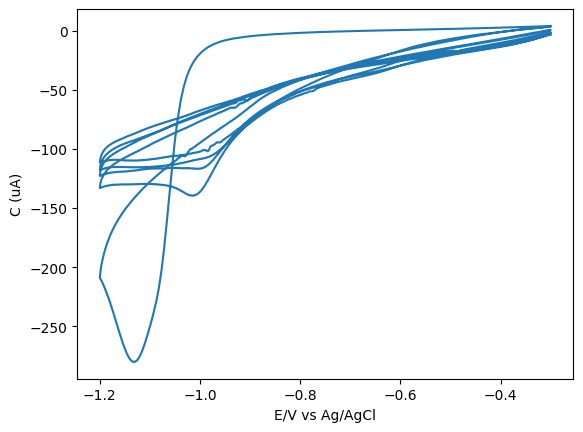

In [4]:
allFiles=[r'C:\Users\bashc\Downloads\scanrate\scan rate']

allFiles = glob.glob(allFiles[0] + "\\*.dta")
allFiles=[r'C:\Users\bashc\Downloads\20231005_token2_11OH_red_des_FA.dta']
CVs={}
cc=0
for dataDir in allFiles:
    #if the extension is .csv then load through a pine
    if os.path.splitext(dataDir)[1]=='.csv' or os.path.splitext(dataDir)[1]=='':
        cv=loadPine(dataDir)
    elif os.path.splitext(dataDir)[1].lower()=='.dta':
        cv=loadGamry(dataDir)
    plt.plot(cv.V,cv.C*1e6,label=os.path.basename(dataDir))
    CVs[os.path.basename(dataDir)]=cv

 
plt.title="All CVs"
plt.xlabel("E/V vs Ag/AgCl")
plt.ylabel("C (uA)") 
 
plt.show()

Reductive
20231005_token2_11OH_red_des_FA.dta
Estimate bandwidth
Mean shift 1
Guassian Fit
Mean shift 2


d:\PythonProj\mlStuff\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\bashc\AppData\Local\Temp\ipykernel_21100\1302609781.py:159: RuntimeWarning: divide by zero encountered in divide
  return A*np.exp( -.5*((x-x0)/sig)**2)


Guassian Fit
Mean shift 3
Guassian Fit


C:\Users\bashc\AppData\Local\Temp\ipykernel_21100\1302609781.py:159: RuntimeWarning: divide by zero encountered in divide
  return A*np.exp( -.5*((x-x0)/sig)**2)


peak 1.1395924257978078 range: 1.0614611610895683,1.2177236905060473 amp:-0.00044340220567694165
Mean shift 4
Guassian Fit
Mean shift 5
Guassian Fit


NameError: name 'bestcurves' is not defined

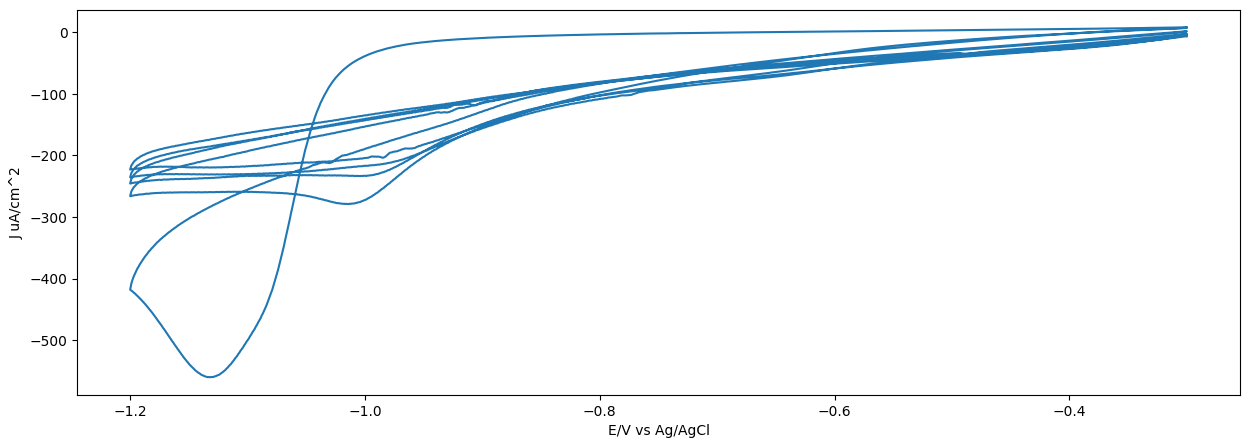

In [6]:

 
 
reductive={}
areaCV={}
onlyCV={}
onlyCVs=False
for cv in CVs:
    potentialMax = CVs[cv].V.max()
    potentialMin = CVs[cv].V.min()
    if onlyCVs:
        print(cv)
        onlyCV[cv]=CVs[cv]
    elif potentialMin<-.8 and potentialMax<1 :
        reductive[cv]=CVs[cv]
    else:
        areaCV[cv]=CVs[cv]

surfaceArea_m2=0
 
for filename in onlyCV:
    try:
        print('Only CV')
        CV=onlyCV[filename]
        DuckParams(filename,CV)
        plt.savefig(outFolder + "\\" + filename + '.jpg')
        plt.show() 
    except:
        pass
    
for filename in areaCV:
    try:
        print('Area')
        fig=plt.figure()
        CalcAreaFromOxide(areaCV [filename],fig)   
        plt.savefig(outFolder + "\\" + filename + '.jpg')
        plt.show() 
    except:
        pass
outFolder=fileFolder
table='Peak Potential (mV), Molecules, Molecules/nm^2, error, Molecules/ cm^2, error\t'
for filename in reductive:
    print('Reductive')
    print(filename)
     
    CV=reductive[filename]
    plt.figure(figsize=(15,5))
    
    area_cm2 = .5 #cm^2
    
    plt.plot(CV.V,CV.C/area_cm2*1e+6,label='Measured')
    CV=CV.loc[(CV.scanrate<0) & (CV.cycle==0)]


    plt.title="Reductive CVs " + filename
    plt.xlabel("E/V vs Ag/AgCl")
    plt.ylabel("J uA/cm^2") 
    guesses,bestcurves,flatCharge,VV=FindMolecules(CV,area_cm2)
    energy=np.sum([x[1]*1/x[0] for x in guesses])/np.sum([1/x[0] for x in guesses])
    Mol=np.sum([x[-1]*1/x[0] for x in guesses])/np.sum([1/x[0] for x in guesses])
    Q=np.sum([x[-2]*1/x[0] for x in guesses])/np.sum([1/x[0] for x in guesses])
    sdMol=np.std([x[-1] for x in guesses])
    #400um diameter
    print(flatCharge)
     
    
    area_um2 = area_cm2*10000*10000
    area_nm2 = area_um2*1000*1000


    textstr=cv+'\nPeak    : %.2f V\nCharge: %0.2f uC\nDensity: %.1f molecules/nm^2\nDensity: %.1f  nm^2/molecule\nDensity: %.2E molecules/cm^2\n'%(  energy, Q*1e6,Mol/area_nm2,area_nm2/Mol,  Mol/area_cm2 )
    textstr=textstr + f'\nCoverage By Charge:{Q*1e6/area_cm2/85*100:.2f} %\n'
    textstr+='Rate    : %d mV/s\n'%(np.mean(CV.scanrate*1000))
    textstr+=f'Simple Coverage By Charge : {flatCharge/85*100:.2f} %\n'
   
    plt.gcf().text(.9,.25,  textstr  , horizontalalignment='right', fontsize=12)

    print( '%.2f V, %.2E +/- %.2E molecules/nm^2, %.2E  +/- %.2E molecules/cm^2'%(  energy, Mol/area_nm2, sdMol/area_nm2, Mol/area_cm2, sdMol/area_cm2))
    table+='%.2f , %.2E,%.2E,%.2E,%.2E'%(  energy, Mol/area_nm2, sdMol/area_nm2, Mol/area_cm2, sdMol/area_cm2)
    plt.legend()
    #plt.xlim([-1.2, .9])
    plt.savefig(outFolder + "\\" + cv + '.jpg')
    plt.show()    
      

In [ ]:

    
 
 
allFiles=[r'C:\Users\bashc\Downloads\scanrate\scan rate']

allFiles = glob.glob(allFiles[0] + "\\*.dta")

CVs={}
cc=0
tables ={}
for dataDir in allFiles:
    #if the extension is .csv then load through a pine
    if os.path.splitext(dataDir)[1]=='.csv' or os.path.splitext(dataDir)[1]=='':
        cv=loadPine(dataDir)
    elif os.path.splitext(dataDir)[1].lower()=='.dta':
        cv=loadGamry(dataDir)
     
    filename = os.path.basename(dataDir)
    params=DuckParams(filename,cv)
    plt.savefig(outFolder + "\\" + filename + '.jpg')
    plt.show() 
    tables[filename]=params
    
    
    

In [363]:
pd.DataFrame(tables).to_csv(outFolder + "\\tables.csv")

C:\Users\bashc\AppData\Local\Temp\ipykernel_14208\3177638092.py:51: RuntimeWarning: invalid value encountered in scalar power
  N=6*(nMolecules/ startMols)**.5


nan


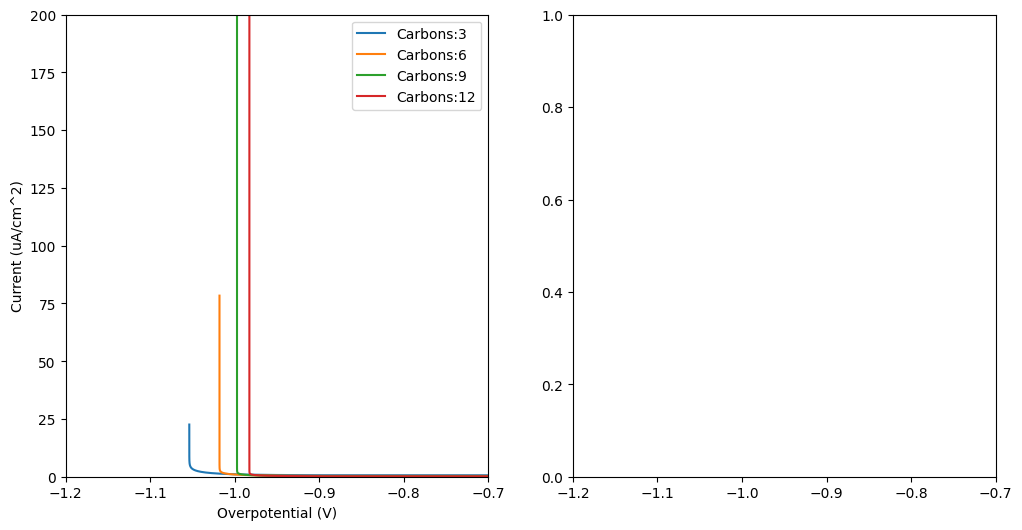

In [265]:

######################## simulation of reductive desorption  #############################
area= .5 #cm^2
nMolecules_nm2 = 4 #molecules/nm^2
scanRate = .1 #V/s
startVoltage = 0 #V
endVoltage = -1.4 #V
peakVoltage=-1.2 #V
herVoltage=-1 #V

fig,ax=plt.subplots(1,2,sharex=True,figsize=(12,6))
for numberCarbonUnits  in range(3,13,3):


    alpha_c=.5
    alpha_a=.5
    z=1   #electrons per reaction
    E0 = 5000*numberCarbonUnits #kJ mol-1/C
    R= 8.314 #J/mol/K 
    F=96485 #C/mol
    T=293  #K

    cap_uF_cm2=1/(1/18*numberCarbonUnits)
    cap_bare_uF_cm2=200

    constant_C =  -1*alpha_c*z*F/R/T
    constant_A =     alpha_c*z*F/R/T

    A= 2/( np.exp(constant_C*peakVoltage ) -np.exp(constant_A*peakVoltage ) )
    HA= 1/( np.exp(constant_C*herVoltage ) -np.exp(constant_A*herVoltage ) )

    B=1/np.exp(-6*E0/R/T)


    nMolecules_cm2 = nMolecules_nm2 * 1e7* 1e7 #molecules/cm^2
    nMolecules = nMolecules_cm2 * area #molecules/100um^2
    startMols=nMolecules

    timeStepsPerSecond=5000 #perSecond
    dt=1/timeStepsPerSecond #s
    duration = np.abs(  (endVoltage-startVoltage)/scanRate ) #s
    nTimesteps=int(duration * timeStepsPerSecond) #timesteps

    current =[] 
    capacitive_current =[]
    pots = []
    Ps=[]
    her = []
    for i in range(nTimesteps):
        overPot = np.abs( i*dt*scanRate) *-1 + startVoltage
        Pe=A* ( np.exp(constant_C*overPot ) -np.exp(constant_A*overPot )    )
        N=6*(nMolecules/ startMols)**.5
        Pn = B*np.exp(-N*E0/R/T)
        Ps.append(Pn)
        P=Pe  *Pn
        change = nMolecules*P *dt
        nMolecules = nMolecules - change
        r= (nMolecules/ startMols) 
        capacitive_current.append( ( r*area*cap_uF_cm2*scanRate + (1-r)*area  *cap_bare_uF_cm2 *scanRate )/area)
        pots.append(overPot)
        current.append(change)
        Pher=HA* ( np.exp(constant_C*overPot ) -np.exp(constant_A*overPot )    )
        her.append( startMols*Pher *1e-6)
    

    current = (np.array(current)+ np.array(her) )/ 6.24150975e18    *1e6/area*dt #uA/cm^2
    current = current + np.array( capacitive_current)
    ax[0].plot(pots,current , label =f'Carbons:{numberCarbonUnits}')
     
     
print(np.max(Ps))
ax[0]. legend()
ax[0].set_xlabel('Overpotential (V)')
ax[0].set_ylabel('Current (uA/cm^2)')
#ax[0].plot(CV['V'],CV['C']*1e6/-.5*175/700, label='Scaled Experimental')
ax[0].set_xlim([-1.2,-.7])
ax[0].set_ylim([0,200])
 

 
plt.show()